In [ ]:
import pandas as pd
import re
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Cargar el dataset
file_path = "./Data/Vinculación_de_personas_con_discapacidad_20250919.csv"
df = pd.read_csv(file_path, sep=None, engine="python")

In [24]:
# 2. Copia de seguridad
df_clean = df.copy()

**ETL:**

In [25]:
# 3. Normalizar nombres de columnas
df_clean.columns = (
    df_clean.columns
    .str.strip()
    .str.upper()
    .str.replace(" ", "_")
    .str.replace(":", "")
    .str.replace("Á", "A")               # para evitar problemas con acentos
    .str.replace("É", "E")
    .str.replace("Í", "I")
    .str.replace("Ó", "O")         
    .str.replace("Ú", "U")
    .str.replace("Ñ", "N")
)

In [26]:
# 4. Reemplazar comas por puntos en coordenadas
df["Latitud"] = df["Latitud"].astype(str).str.replace(",", ".").astype(float)
df["Longitud"] = df["Longitud"].astype(str).str.replace(",", ".").astype(float)

In [27]:
# 5. Convertir columnas numéricas que vienen como texto
for col in ["Vinculados", "meta_vinculacion", "Salario mensual promedio"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

In [28]:
# 6. Corregir año (algunos vienen con comas)
df["Año"] = df["Año"].astype(str).str.replace(",", "").astype(int)

In [29]:
# 7. Definir columnas que quiero conservar como claves
id_vars = [
    'Código SIGEP', 'Nombre de la entidad', 'Nit', 'Orden', 'Suborden',
    'Código DIVIPOLA Departamento', 'Departamento',
    'Código DIVIPOLA Municipio ', 'Municipio',
    'Clasificación Orgánica', 'Sector', 'Nivel',
    'Tipo de Vinculacíon ', 'Naturaleza jurídica ',
    'Longitud', 'Latitud', 'Año', 'Trimestre',
    'Fuente', 'Salario mensual promedio',
    'Vinculados', 'meta_vinculacion', 'cumplimiento'
]

In [30]:
# 8. Transformar columnas categóricas a vertical
df_long = pd.melt(
    df,
    id_vars=id_vars,
    var_name="categoria",
    value_name="valor"
)

In [31]:
# 9. Limpiar: eliminar solo valores nulos
df_long = df_long[df_long["valor"].notna()]

In [ ]:
print(df_long.head(20))

In [32]:
# 10. Eliminar columnas innecesarias
cols_to_drop = [
    'Código SIGEP', 'Nit', 'Código DIVIPOLA Departamento',
    'Código DIVIPOLA Municipio ', 'Nivel', 'Tipo de Vinculacíon ',
    'Trimestre', 'Fuente'
]
df_long = df_long.drop(columns=cols_to_drop)

In [ ]:
print(df_long.head(20))

In [33]:
# 11. Crear nueva columna con la parte antes de los dos puntos
df_long["categoria_general"] = df_long["categoria"].str.split(":").str[0]

In [ ]:
print(df_long.head(20))

In [34]:
# 12) Función de limpieza: normaliza acentos, pasa a mayúsculas y quita caracteres especiales
def clean_text(s):
    if pd.isna(s):
        return s
    s = str(s)
    # Normalizar acentos (Á -> A, etc.)
    s = unicodedata.normalize('NFKD', s).encode('ASCII', 'ignore').decode('ASCII')
    # Pasar a mayúsculas
    s = s.upper()
    # Quitar cualquier caracter que no sea A-Z, 0-9 o espacio
    s = re.sub(r'[^A-Z0-9\s]', '', s)
    # Colapsar múltiples espacios y strip
    s = re.sub(r'\s+', ' ', s).strip()
    return s

In [35]:
# 13) Aplicar limpieza solo a columnas de tipo object (texto)
text_cols = df_long.select_dtypes(include="object").columns.tolist()
for col in text_cols:
    df_long[col] = df_long[col].apply(clean_text)

In [36]:
print(df_long.head(20))

                                 Nombre de la entidad        Orden  \
0                                  ALCALDIA DE MAICAO  TERRITORIAL   
1                               ALCALDIA DE CHINCHINA  TERRITORIAL   
2                              ALCALDIA DE COPACABANA  TERRITORIAL   
3                  UNIVERSIDAD TECNOLOGICA DE PEREIRA     NACIONAL   
4                           ALCALDIA DE RIOFRIO VALLE  TERRITORIAL   
5                                   ALCALDIA DE YUMBO  TERRITORIAL   
6                       ALCALDIA DE LA CEJA DEL TAMBO  TERRITORIAL   
7                                 ALCALDIA DE PIVIJAY  TERRITORIAL   
8                      ALCALDIA DE SAN MIGUEL DE SEMA  TERRITORIAL   
9                               ALCALDIA DE SANTUARIO  TERRITORIAL   
10                              ALCALDIA DE TOCANCIPA  TERRITORIAL   
11                                  CONCEJO DE GUICAN  TERRITORIAL   
12                                   CONCEJO DE FUNZA  TERRITORIAL   
13  DEPARTAMENTO ADM

**EDA:**

In [37]:
# 1. Resumen general
print("Dimensiones:", df_long.shape)
print("\nTipos de datos:")
print(df_long.dtypes)
print("\nValores nulos por columna:")
print(df_long.isna().sum())
print("\nEstadísticas descriptivas (numéricas):")
print(df_long.describe())

Dimensiones: (177674, 18)

Tipos de datos:
Nombre de la entidad         object
Orden                        object
Suborden                     object
Departamento                 object
Municipio                    object
Clasificación Orgánica       object
Sector                       object
Naturaleza jurídica          object
Longitud                    float64
Latitud                     float64
Año                           int64
Salario mensual promedio      int64
Vinculados                  float64
meta_vinculacion            float64
cumplimiento                 object
categoria                    object
valor                         int64
categoria_general            object
dtype: object

Valores nulos por columna:
Nombre de la entidad            0
Orden                           0
Suborden                       49
Departamento                   49
Municipio                      49
Clasificación Orgánica          0
Sector                          0
Naturaleza jurídica          

In [ ]:
# 2. Análisis de variables categóricas
print("\nTop categorias generales:")
print(df_long["categoria_general"].value_counts().head(10))


Top categorias generales:
categoria_general
TIPO NOMBRAMIENTO       50764
NIVEL EDUCATIVO         29008
TIPO DE DISCAPACIDAD    25382
ESTADO CIVIL            21756
EDAD                    21756
NUMERO HIJOS            21756
SEXO                     7252
Name: count, dtype: int64


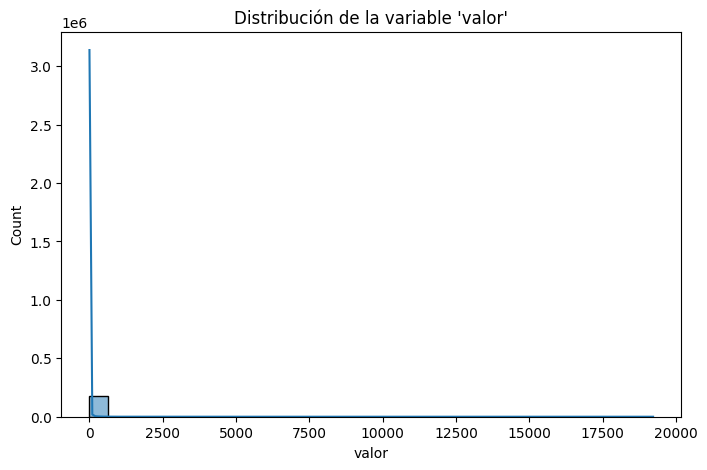

In [ ]:
# 3. Distribución de la variable 'valor'
plt.figure(figsize=(8,5))
sns.histplot(df_long["valor"], bins=30, kde=True)
plt.title("Distribución de la variable 'valor'")
plt.show()

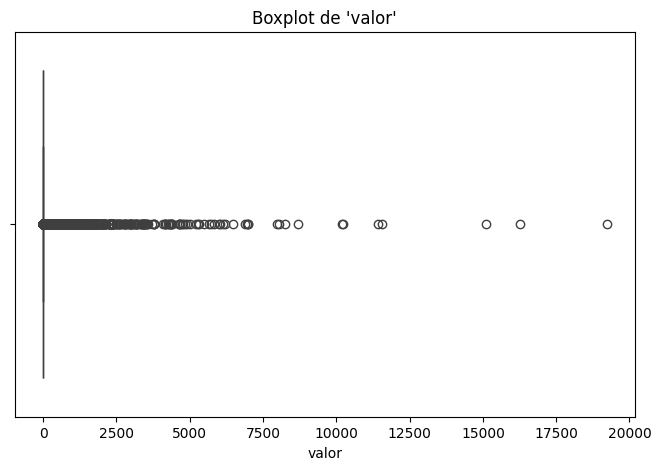

In [41]:
# 4. Boxplot de 'valor' para detectar outliers
plt.figure(figsize=(8,5))
sns.boxplot(x=df_long["valor"])
plt.title("Boxplot de 'valor'")
plt.show()

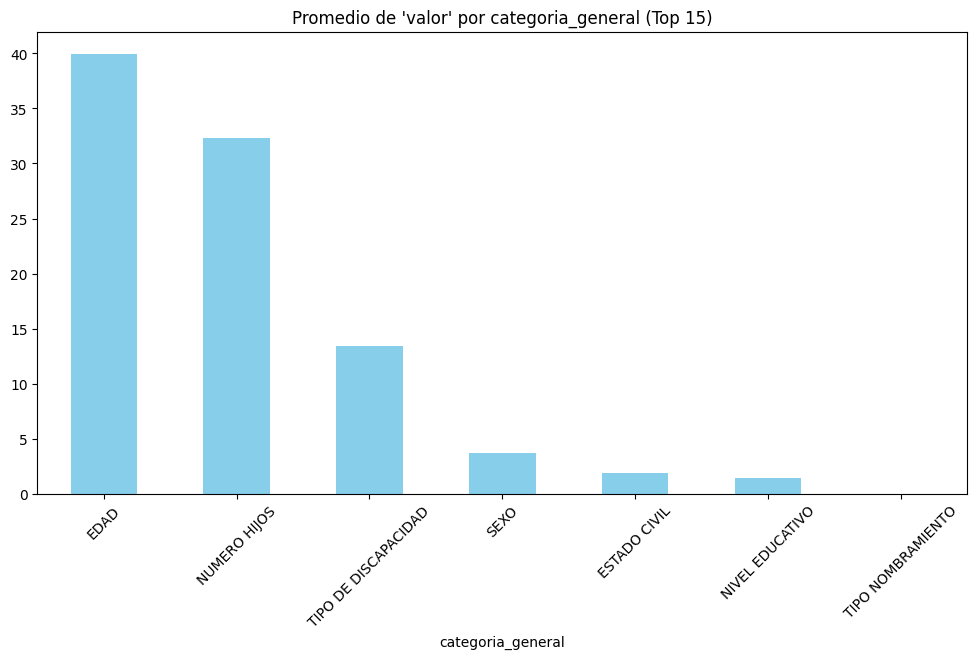

In [42]:
# 5. Promedio de valor por categoria_general
plt.figure(figsize=(12,6))
df_long.groupby("categoria_general")["valor"].mean().sort_values(ascending=False).head(15).plot(kind="bar", color="skyblue")
plt.title("Promedio de 'valor' por categoria_general (Top 15)")
plt.xticks(rotation=45)
plt.show()

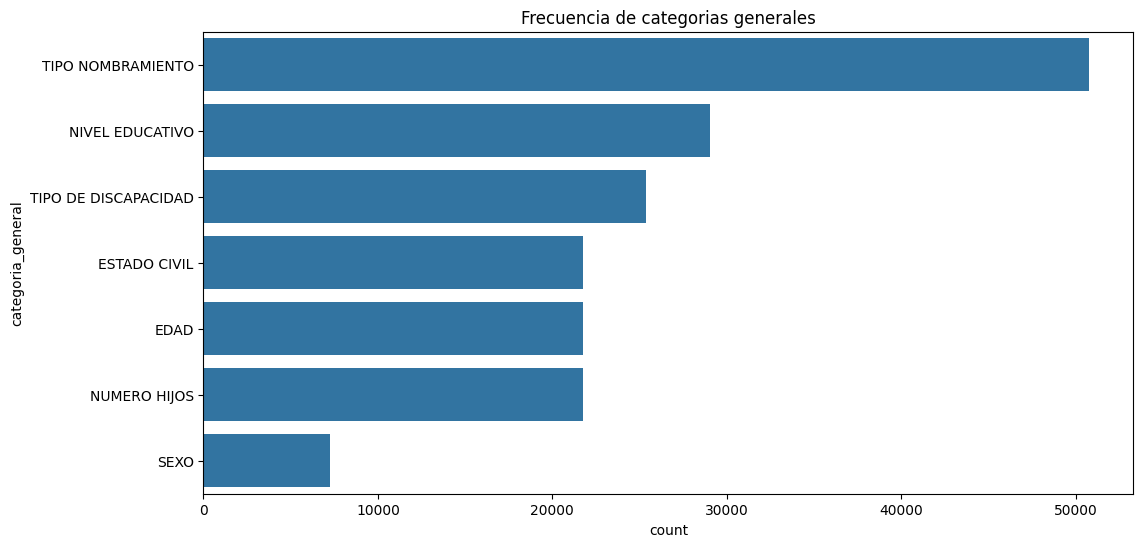

In [44]:
# 6. Conteo de registros por categoria_general
plt.figure(figsize=(12,6))
sns.countplot(data=df_long, y="categoria_general", order=df_long["categoria_general"].value_counts().index)
plt.title("Frecuencia de categorias generales")
plt.show()

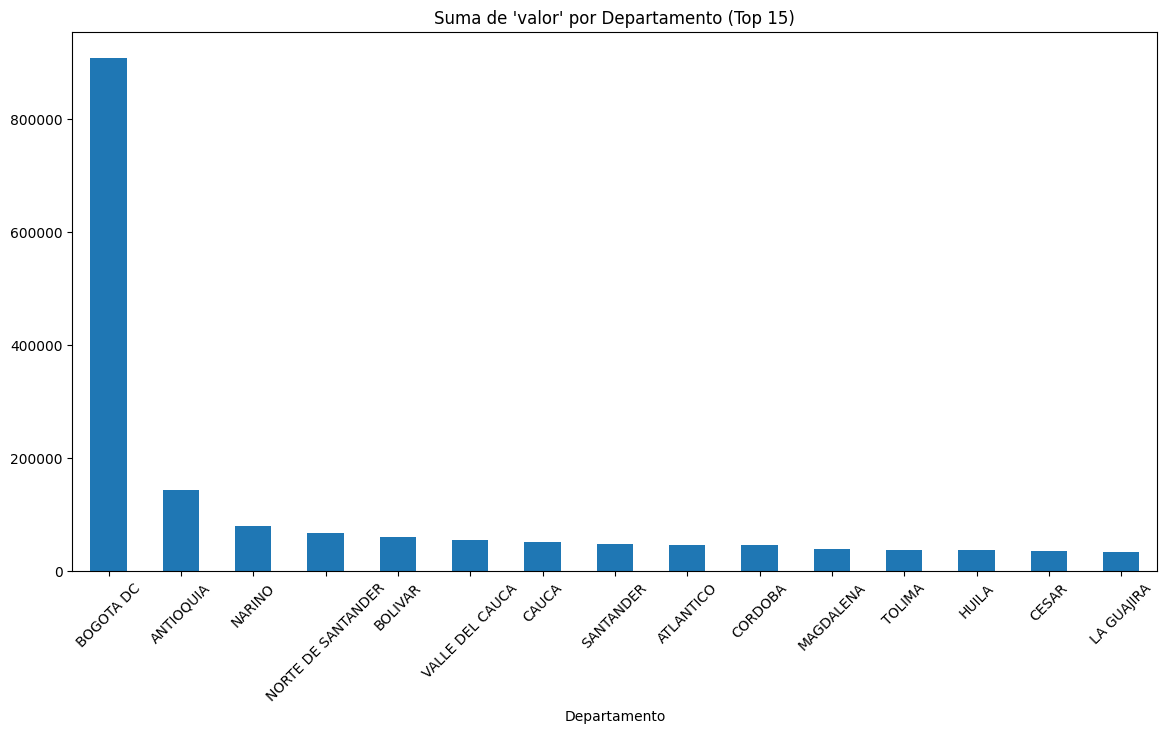

In [45]:
# 7. Distribución de valores por Departamento
plt.figure(figsize=(14,7))
df_long.groupby("Departamento")["valor"].sum().sort_values(ascending=False).head(15).plot(kind="bar")
plt.title("Suma de 'valor' por Departamento (Top 15)")
plt.xticks(rotation=45)
plt.show()

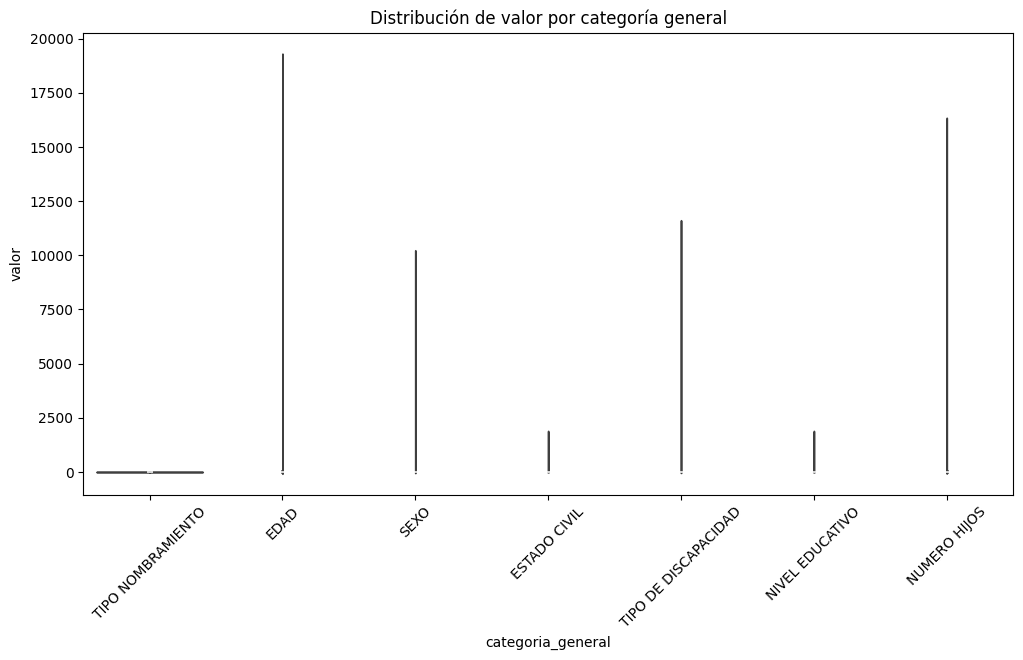

In [49]:
# 8. Distribución de valores por categoría con violinplots

plt.figure(figsize=(12,6))
sns.violinplot(data=df_long, x="categoria_general", y="valor", inner="box")
plt.xticks(rotation=45)
plt.title("Distribución de valor por categoría general")
plt.show()

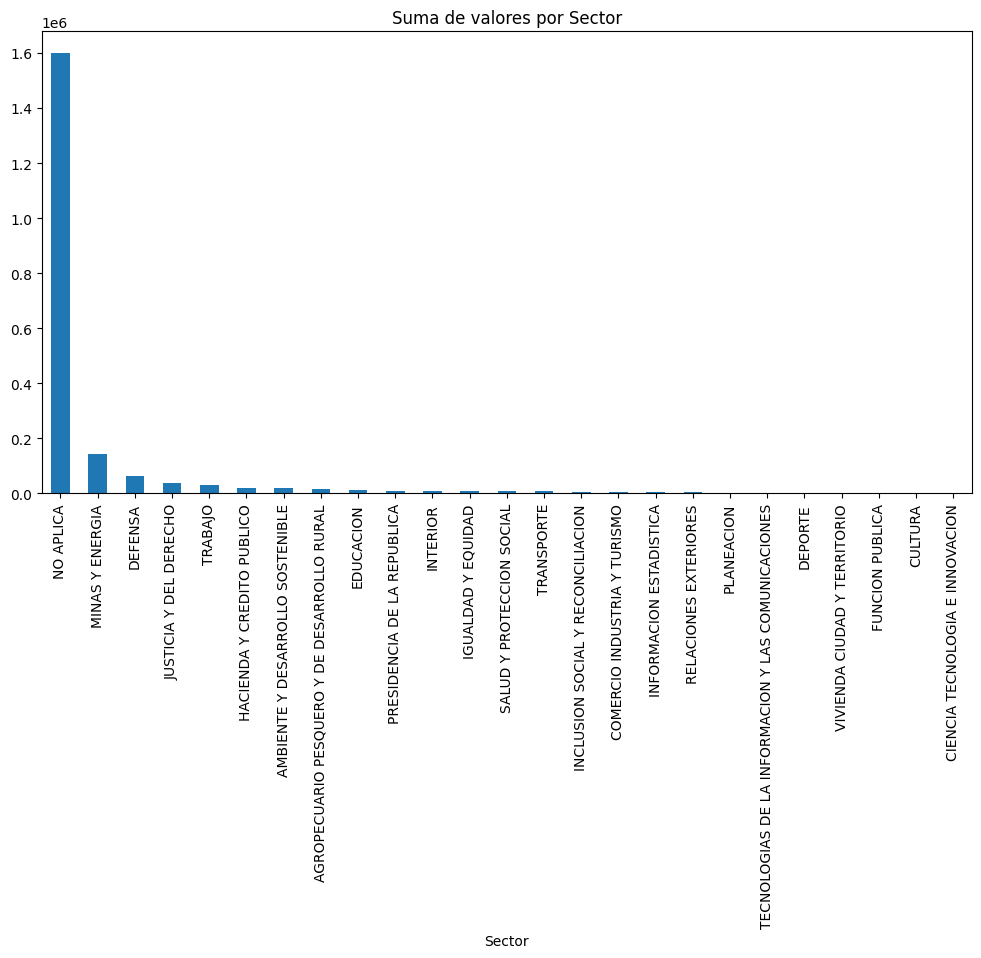

In [50]:
# 9. Relación entre Sector y Valor

df_long.groupby("Sector")["valor"].sum().sort_values(ascending=False).plot(kind="bar", figsize=(12,6))
plt.title("Suma de valores por Sector")
plt.show()

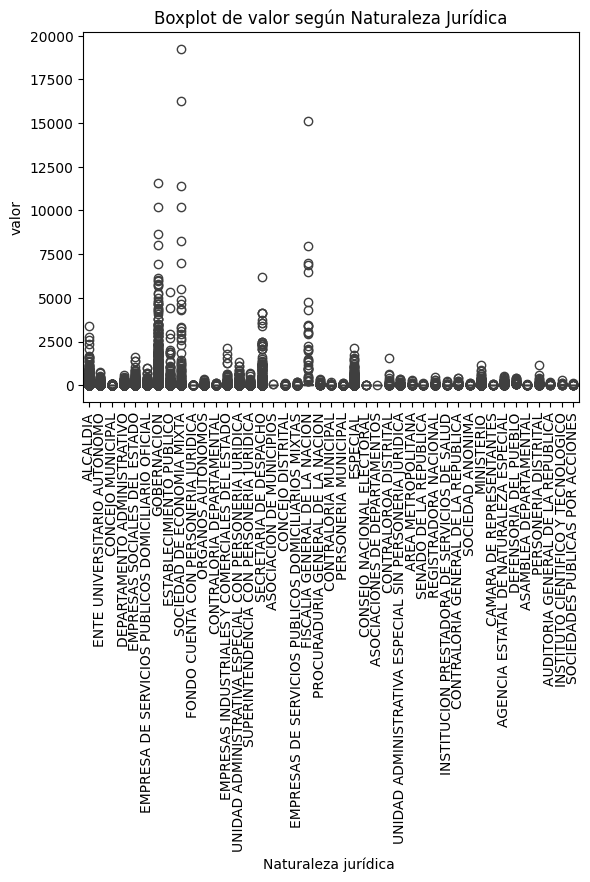

In [52]:
# 10. Naturaleza Jurídica vs Valor

sns.boxplot(data=df_long, x="Naturaleza jurídica ", y="valor")
plt.xticks(rotation=90)
plt.title("Boxplot de valor según Naturaleza Jurídica")
plt.show()

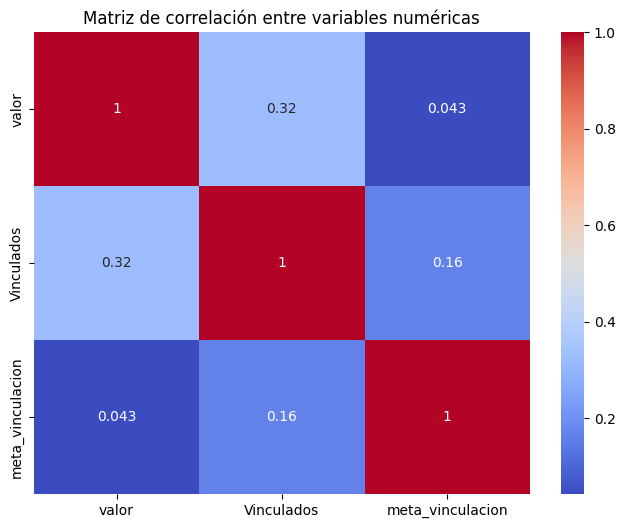

In [55]:
# 11. Correlaciones entre variables numéricas

plt.figure(figsize=(8,6))
sns.heatmap(df_long[["valor","Vinculados","meta_vinculacion"]].corr(), annot=True, cmap="coolwarm")
plt.title("Matriz de correlación entre variables numéricas")
plt.show()

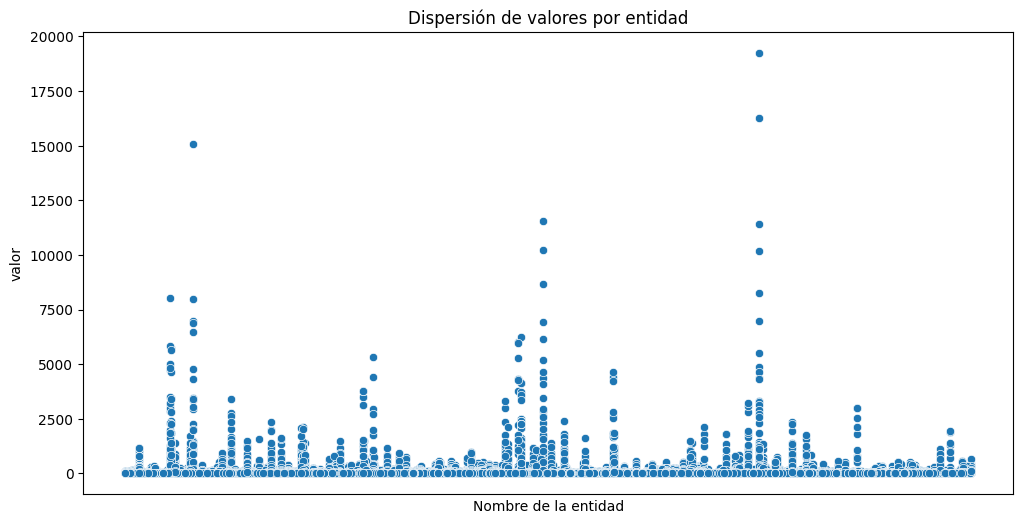

In [57]:
# 12. Detección de outliers por entidad

plt.figure(figsize=(12,6))
sns.scatterplot(data=df_long, x="Nombre de la entidad", y="valor")
plt.xticks([], [])                                         # se ocultan los ticks para que no se vea recargado
plt.title("Dispersión de valores por entidad")
plt.show()

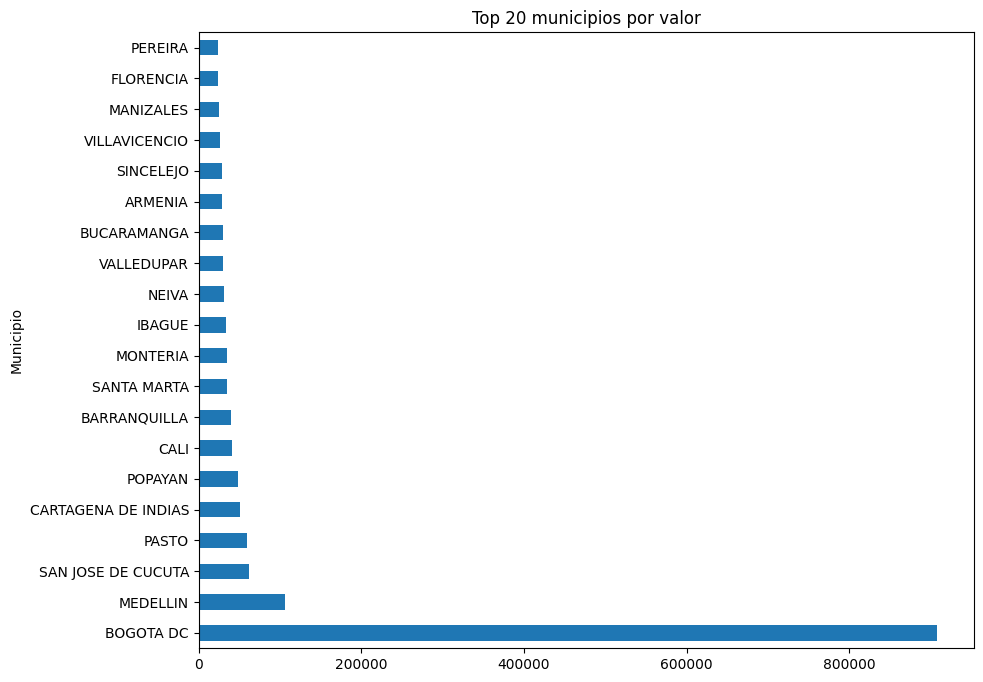

In [58]:
# 13. Ranking de los Top N municipios

df_long.groupby("Municipio")["valor"].sum().nlargest(20).plot(kind="barh", figsize=(10,8))
plt.title("Top 20 municipios por valor")
plt.show()

In [20]:
output_path = "C:/Users/andpu/OneDrive/Escritorio/ESPECIALIZACION EN ANALITICA DE BIG DATA/SEMESTRE 1/GESTION Y ALMACENAMIENTO DE DATOS/Proyecto Final/Data/vinculacion_largo_limpio.csv"
df_long.to_csv(output_path, index=False, encoding="utf-8-sig")
print("CSV generado en:", output_path)

CSV generado en: C:/Users/andpu/OneDrive/Escritorio/ESPECIALIZACION EN ANALITICA DE BIG DATA/SEMESTRE 1/GESTION Y ALMACENAMIENTO DE DATOS/Proyecto Final/Data/vinculacion_largo_limpio.csv
